In [14]:
%load_ext autoreload

import sys
sys.path.insert(0, '..')

import torch
from torch import nn
from external.QuaterNet.common import quaternion
import numpy as np
import math
import matplotlib.pyplot as plt

from models import super_shape
from models import super_shape_sampler
from models import periodic_shape_sampler
from models import periodic_shape_sampler_xyz
import utils
from visualize import plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([-0.0454, -0.0911, -0.0299,  0.0090,  0.0015,  0.0138,  0.0537,  0.0095,
        -0.0454], grad_fn=<ViewBackward>)
tensor([True, True, True, True, True, True, True, True, True])
tensor([-180.0000, -135.0000,  -90.0000,  -45.0000,    0.0000,   45.0000,
          90.0000,  135.0000,  180.0000])


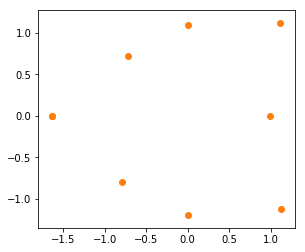

In [15]:
batch = 1
m = 3
n = 1
n1 = 1
n2 = 10
n3 = 3
a = 1
b = 1
P = 50
dim = 2
sample_num = 9
points_num = 7

rotations = [[0.]] * n
#transitions = [[0., 0.], [1., 0]]
transitions = [[0., 0.]]

linear_scales = [[1., 1.]] * n

preset_params = utils.generate_multiple_primitive_params(
    m,
    n1,
    n2,
    n3,
    a,
    b,
    rotations_angle=rotations,
    transitions=transitions,
    linear_scales=linear_scales,
    nn=n)

thetas = utils.sample_spherical_angles(
    sample_num=sample_num, batch=batch, dim=dim)
sampler = periodic_shape_sampler_xyz.PeriodicShapeSamplerXYZ(points_num, m, n, dim=dim)
sampler.eval()
points = torch.ones([batch, points_num, dim]).float()
# B, N, P
radius = sampler.transform_circumference_angle_to_super_shape_radius(
    thetas, preset_params, points=points)
# B, P, dim
coord = sampler.transform_circumference_angle_to_super_shape_world_cartesian_coord(
    thetas, radius, preset_params, points=points).view(batch, -1, dim)

sgn = sampler.transform_world_cartesian_coord_to_tsd(
    coord, preset_params, points=points)

fig = plt.figure()
g = fig.add_subplot(1, 1, 1)
plot.plot_primitive_point_cloud_2d(g, coord, s=10)

x = coord[0, :, 0].detach().cpu().numpy()
y = coord[0, :, 1].detach().cpu().numpy()
sgn = sgn.view(-1)
print(sgn)

error_idx =  ~((-1e-5 < sgn) & (sgn < 1e-5))
print(error_idx)
g.scatter(x[error_idx], y[error_idx])
error_thetas = thetas.view(-1)[error_idx]
print(error_thetas/math.pi * 180.)

#assert torch.allclose(sgn, torch.zeros_like(sgn),
#                                  atol=1e-5), (sgn.min(), sgn.max())

In [16]:
batch = 3
m = 4
n = 1
n1 = 1
n2 = 1
n3 = 1
a = 1
b = 1
theta = math.pi / 2.
sample_num = 200
points_num = 5

dim = 2

rotations = [[0.]]
transitions = [[0., 0.]]
linear_scales = [[1., 1.]]

sampler = periodic_shape_sampler_xyz.PeriodicShapeSamplerXYZ(points_num,
                                                                m,
                                                                n,
                                                                last_scale=.1,
                                                                dim=dim)
sampler = super_shape_sampler.SuperShapeSampler(m, n, dim=dim)
preset_params = utils.generate_multiple_primitive_params(
    m,
    n1,
    n2,
    n3,
    a,
    b,
    rotations_angle=rotations,
    transitions=transitions,
    linear_scales=linear_scales,
    nn=n)

batched_theta_test_tensor = utils.sample_spherical_angles(
    sample_num=sample_num, batch=batch, dim=dim)

batched_points = torch.zeros([batch, points_num, dim]).float()

# B, N, P
radius = sampler.transform_circumference_angle_to_super_shape_radius(
    batched_theta_test_tensor, preset_params, points=batched_points)
# B, P, dim
coord = sampler.transform_circumference_angle_to_super_shape_world_cartesian_coord(
    batched_theta_test_tensor,
    radius,
    preset_params,
    points=batched_points).view(batch, -1, dim)

sgn = sampler.transform_world_cartesian_coord_to_tsd(coord,
                                                        preset_params,
                                                        points=batched_points)


In [17]:


"""
surafce_points_list = [surface_points1]
fig = plt.figure()
for idx, surface_points in enumerate(surafce_points_list):
    g = fig.add_subplot(1, len(surafce_points_list), idx+1)
    plot.plot_primitive_point_cloud_2d(g, surface_points)

tsd_list = [tsd1]
fig = plt.figure()
for idx, tsd in enumerate(tsd_list):
    g = fig.add_subplot(1, len(tsd_list), idx+1)
    plot.draw_primitive_inside_2d(g, tsd, coord)
"""


'\nsurafce_points_list = [surface_points1]\nfig = plt.figure()\nfor idx, surface_points in enumerate(surafce_points_list):\n    g = fig.add_subplot(1, len(surafce_points_list), idx+1)\n    plot.plot_primitive_point_cloud_2d(g, surface_points)\n\ntsd_list = [tsd1]\nfig = plt.figure()\nfor idx, tsd in enumerate(tsd_list):\n    g = fig.add_subplot(1, len(tsd_list), idx+1)\n    plot.draw_primitive_inside_2d(g, tsd, coord)\n'